# Intel Image Classification (CNN - Keras)

Hello, I hope you are having a great day.

In this notebook, I will try the process of implementing CNN with Keras in order to classify images.
1. Firstly, we'll import usefull packages.
1. Then, we'll load the data, before visualize and preprocess it.
1. We'll use a CNN model and then we will evaluate its performances.

# Import Packages

In [8]:
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle           
import matplotlib.pyplot as plt             
import cv2                                 
import tensorflow as tf                
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [41]:
class_names = ['Flat', 'Gable', 'Hip']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (150, 150)

# Loading the Data
We have to write a load_data function that load the images and the labels from the folder.

In [42]:
def load_data():
    """
        Load the data:
            - 14,034 images to train the network.
            - 3,000 images to evaluate how accurately the network learned to classify images.
    """
    
    datasets = ['classification/Train', 'classification/Validate']
    output = []
    
    # Iterate through training and test sets
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE) 
                
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

In [43]:
(train_images, train_labels), (test_images, test_labels) = load_data()

Loading classification/Train


100%|██████████| 3360/3360 [00:01<00:00, 1921.73it/s]


Loading classification/Validate


100%|██████████| 960/960 [00:07<00:00, 123.00it/s]


In [44]:
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)

# Let's explore the dataset
We can ask ourselves:
* How many training and testing examples do we have ?
* What is the size of the images ?
* What is the proportion of each observed category ?

In [45]:
n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

print ("Number of training examples: {}".format(n_train))
print ("Number of testing examples: {}".format(n_test))
print ("Each image is of size: {}".format(IMAGE_SIZE))

Number of training examples: 10080
Number of testing examples: 2880
Each image is of size: (150, 150)


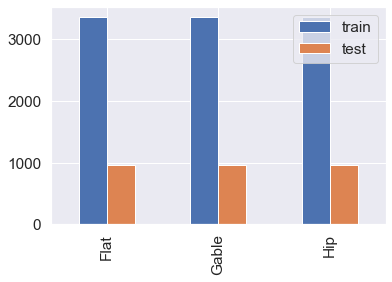

In [46]:
import pandas as pd

_, train_counts = np.unique(train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)
pd.DataFrame({'train': train_counts,
                    'test': test_counts}, 
             index=class_names
            ).plot.bar()
plt.show()

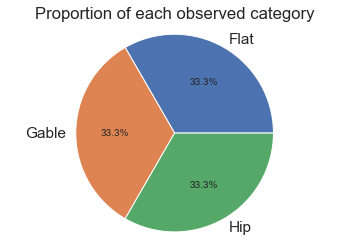

In [47]:
plt.pie(train_counts,
        explode=(0, 0, 0) , 
        labels=class_names,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proportion of each observed category')
plt.show()

## Good practice: scale the data

In [48]:
train_images = train_images / 255.0 
test_images = test_images / 255.0

## Visualize the data
We can display a random image from the training set.

In [49]:
def display_random_image(class_names, images, labels):
    """
        Display a random image from the images array and its correspond label from the labels array.
    """
    
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{} : '.format(index) + class_names[labels[index]])
    plt.show()

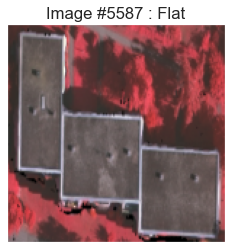

In [50]:
display_random_image(class_names, train_images, train_labels)

We can also display the first 25 images from the training set directly with a loop to get a better view

In [51]:
def display_examples(class_names, images, labels):
    """
        Display 25 images from the images array with its corresponding labels
    """
    
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some examples of images of the dataset", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()

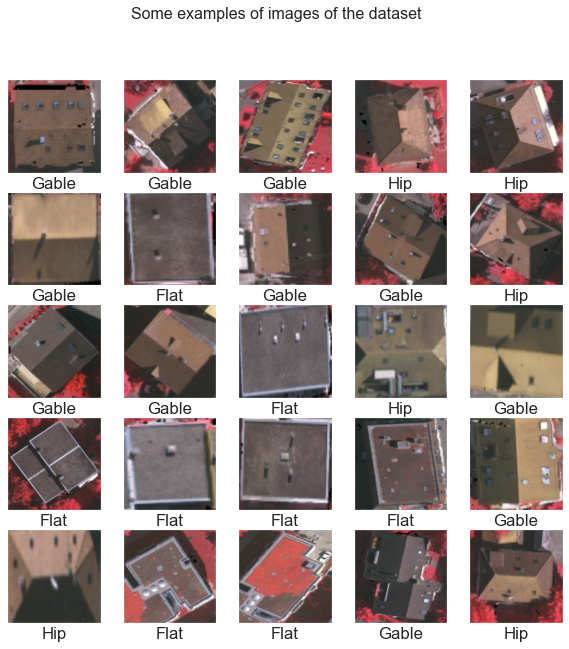

In [52]:
display_examples(class_names, train_images, train_labels)

# CNN Model Creation

In [3]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(3, activation=tf.nn.softmax)
])

In [26]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics=['accuracy','Precision','Recall'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 74, 74, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 43808)             0         
                                                                 
 dense (Dense)               (None, 128)               5

In [27]:
datagen = ImageDataGenerator(rescale=1.0/255.0)

train_it = datagen.flow_from_directory('classification/Train', batch_size=500, target_size=(150, 150), class_mode="categorical")
eval_it = datagen.flow_from_directory('classification/Validate', batch_size=100, target_size=(150, 150), class_mode="categorical")

early = EarlyStopping(monitor="val_accuracy", patience=10) 
history = model.fit(train_it, epochs=20, validation_data=eval_it, callbacks=[early])

Found 10080 images belonging to 3 classes.
Found 2880 images belonging to 3 classes.
Epoch 1/20
21/21 [==============================] - 119s 6s/step - loss: 1.8173 - accuracy: 0.3884 - precision: 0.4406 - recall: 0.1813 - val_loss: 0.9502 - val_accuracy: 0.5809 - val_precision: 0.9433 - val_recall: 0.1792
Epoch 2/20
21/21 [==============================] - 14s 685ms/step - loss: 0.7744 - accuracy: 0.6820 - precision: 0.8327 - recall: 0.4213 - val_loss: 0.6316 - val_accuracy: 0.7781 - val_precision: 0.8365 - val_recall: 0.6128
Epoch 3/20
21/21 [==============================] - 15s 709ms/step - loss: 0.5457 - accuracy: 0.8018 - precision: 0.8446 - recall: 0.7220 - val_loss: 0.5224 - val_accuracy: 0.8076 - val_precision: 0.8374 - val_recall: 0.7437
Epoch 4/20
21/21 [==============================] - 15s 724ms/step - loss: 0.4724 - accuracy: 0.8126 - precision: 0.8359 - recall: 0.7749 - val_loss: 0.4692 - val_accuracy: 0.8104 - val_precision: 0.8323 - val_recall: 0.7701
Epoch 5/20
21/21 

In [30]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "acc")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

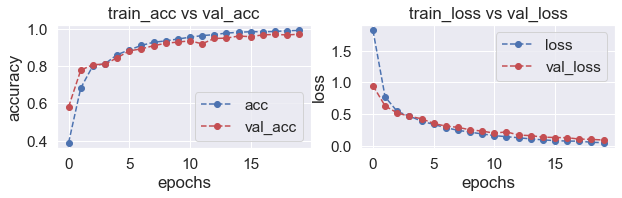

In [31]:
plot_accuracy_loss(history)

In [28]:
model.save('finalmodel.h5')

In [29]:
model.save_weights("finalmodelweights.h5")

In [32]:
from tensorflow import keras
model = keras.models.load_model('savesimple.h5')

We should evaluate the model performance on test set

In [53]:
test_loss = model.evaluate(test_images, test_labels)

90/90 [==============================] - 1s 10ms/step - loss: 0.0743 - accuracy: 0.9858


90/90 [==============================] - 2s 11ms/step


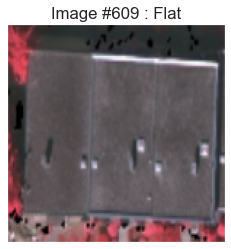

In [54]:
predictions = model.predict(test_images)     # Vector of probabilities
pred_labels = np.argmax(predictions, axis = 1) # We take the highest probability

display_random_image(class_names, test_images, pred_labels)

## Error analysis

We can try to understand on which kind of images the classifier has trouble.

In [55]:
def print_mislabeled_images(class_names, test_images, test_labels, pred_labels):
    """
        Print 25 examples of mislabeled images by the classifier, e.g when test_labels != pred_labels
    """
    BOO = (test_labels == pred_labels)
    mislabeled_indices = np.where(BOO == 0)
    mislabeled_images = test_images[mislabeled_indices]
    mislabeled_labels = pred_labels[mislabeled_indices]

    title = "Some examples of mislabeled images by the classifier:"
    display_examples(class_names,  mislabeled_images, mislabeled_labels)


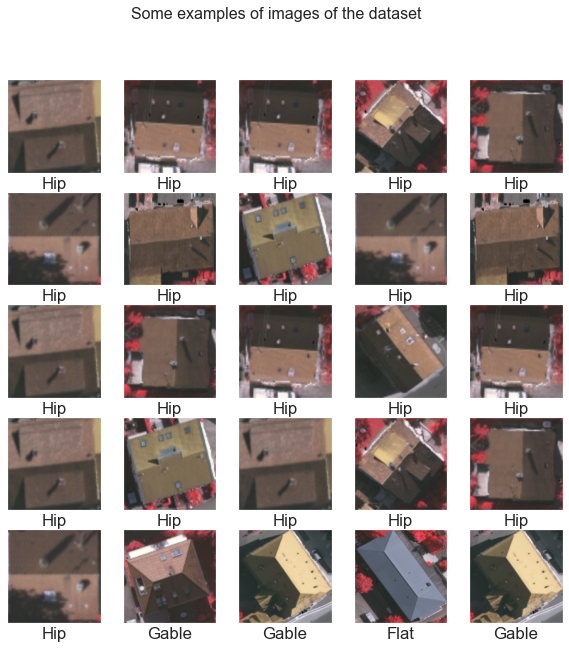

In [56]:
print_mislabeled_images(class_names, test_images, test_labels, pred_labels)

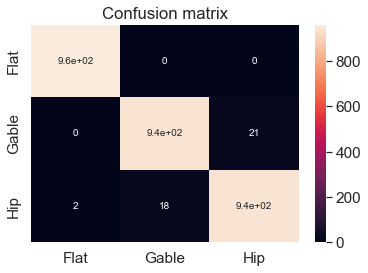

In [57]:
CM = confusion_matrix(test_labels, pred_labels)
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix')
plt.show()

In [84]:
from sklearn.metrics import confusion_matrix
import keras

y_true = np.array(eval_it.labels)
y_pred = pred_labels
print(y_pred)
print(y_true)

[0 0 0 ... 2 2 2]
[0 0 0 ... 2 2 2]


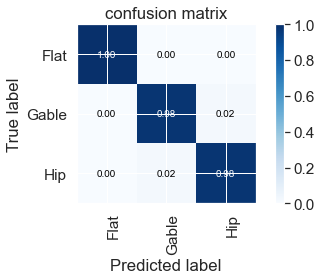

In [91]:
classes = ['Flat','Gable', 'Hip']

def plot_confusion_matrix(ytrue, y_pred,classes,
                          title=None,
                          cmap=plt.cm.Blues):

    # Compute confusion matrix
    cm = confusion_matrix(ytrue, y_pred)
    
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

# Plot normalized confusion matrix
plot_confusion_matrix(y_true, y_pred, classes=classes, title='confusion matrix')
plt.show()

## Conclusion: The classifier has trouble with 2 kinds of images.
It has trouble with street and buildings. Well, it can be understandable as as there are buildings in the street. 
It has also trouble with sea, glacier and moutain as well. It is hard for me to fully distinguish them.
However, it can detects forest very accurately!

## Visualize the features through PCA

In [58]:
train_features = model.predict(train_images)
test_features = model.predict(test_images)

90/90 [==============================] - 1s 8ms/step


In [59]:
n_train, n = train_features.shape
n_test, n = test_features.shape
numFeatures = n

In [60]:
from sklearn import decomposition

pca = decomposition.PCA(n_components = 3)

X = train_features.reshape((n_train, 3))
pca.fit(X)

C = pca.transform(X) # Représentation des individus dans les nouveaux axe
C1 = C[:,0]
C2 = C[:,1]

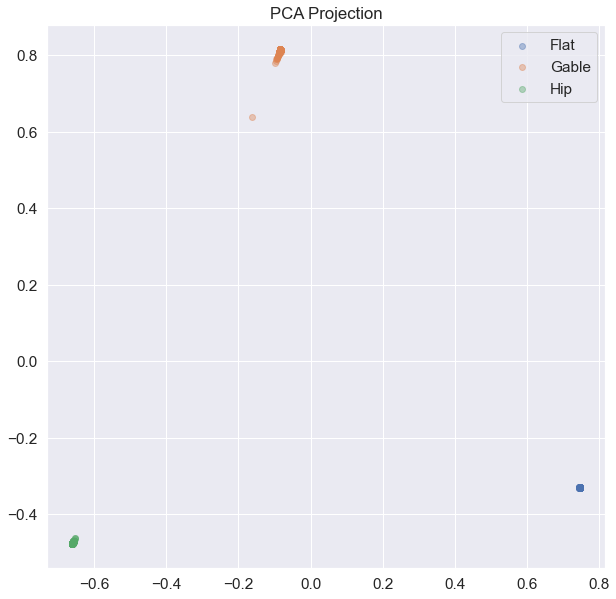

In [61]:
plt.subplots(figsize=(10,10))

for i, class_name in enumerate(class_names):
    plt.scatter(C1[train_labels == i][:1000], C2[train_labels == i][:1000], label = class_name, alpha=0.4)
plt.legend()
plt.title("PCA Projection")
plt.show()

We see that there is no distinction between the types.

In [79]:
class_names_label

{'Flat': 0, 'Gable': 1, 'Hip': 2}

In [151]:
def predictlabel(imgpath):
    img=load_img(imgpath,target_size=(150,150)); #loading image and then convert it into grayscale and with it's target size 
    img=img_to_array(img)
    img = img/255
    proba = model.predict(img.reshape(1,150,150,3))
    top_3 = np.argsort(proba[0])[:-4:-1]
    return class_names[top_3[0]]

predictlabel('classification\Test\Flat14.tif')

1/1 [==============================] - 0s 19ms/step


'Flat'

In [3]:
import numpy as np
import pandas as pd
from keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from skimage import color
from PIL import Image
import keras
import cv2
import os
import matplotlib.pyplot as plt 

1/1 [==============================] - 0s 58ms/step
['Gable', 'Hip', 'Flat']
--
[1 2 0]
['Flat', 'Gable', 'Hip']


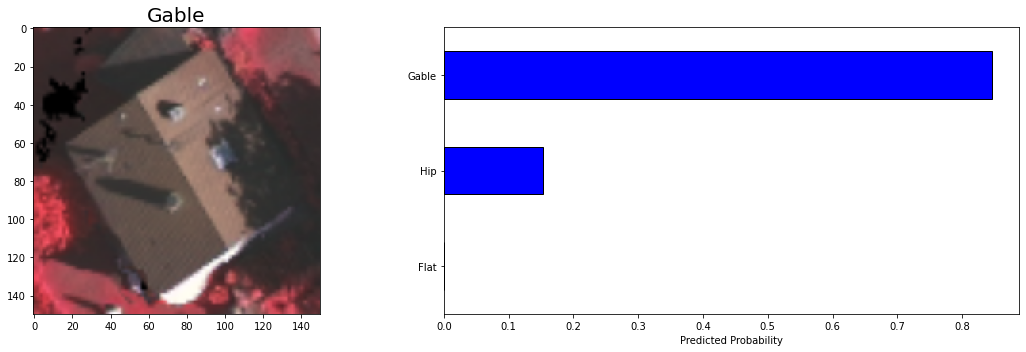

In [4]:
def predictType(imgpath):
    img=load_img(imgpath,target_size=(150,150)) #loading image and then convert it into grayscale and with it's target size 
    img=img_to_array(img)
    img = img/255
    proba = model.predict(img.reshape(1,150,150,3))
    top_3 = np.argsort(proba[0])[:-4:-1]
    topclasses = []
    for i in range(3):
        topclasses.append(classes[top_3[i]])
    print(topclasses)
    print('--')
    return img, proba[0], top_3, classes

    
def display_prediction(image_path, model, topk):
    """Display image and preditions from model"""

    # Get predictions
    img, ps, top, topclasses = predictType(image_path)
    print(top)
    print(topclasses)
    # Convert results to dataframe for plotting
    result = pd.DataFrame({'p': ps}, index=topclasses)
    # Show the image
    plt.figure(figsize=(16, 5))
    plt.subplot(121)
    plt.imshow(img)
    plt.title(classes[top[0]], size=20)

    plt.subplot(122)
    result.sort_values('p')['p'].plot.barh(color='blue', edgecolor='k')
    plt.xlabel('Predicted Probability')
    plt.tight_layout()

classes = ['Flat','Gable', 'Hip']
model = keras.models.load_model('finalmodel.h5')
display_prediction('Gable14.tif', model, 3)
